In [ ]:
!pip install networkx
!pip install powerlaw
!pip install python-louvain

In [1]:
# Para visuzalización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
import seaborn as sns

# Números y Datos
import numpy as np
import pandas as pd

import networkx as nx
import community
import powerlaw

from sklearn.metrics import adjusted_rand_score

# Tutorial de networkx (analisis de redes sociales)

## Análisis de una comunidad de windsurfers 

Para este tutorial vamos a utilizar los datos de dos comunidades de windsurfers en una playa del sur de California, en 1986. Los investigadores que llevaron a cabo este trabajo observaron a un grupo de 43 windsurfers durante 31 días. A partir de estas observaciones determinaron la red de contactos y además al final de las observaciones realizaron una encuesta para determinar cuáles eran las relaciones que reportaban los individuos observados.

Es decir que se pueden construir dos redes, una con las interacciones observadas y otra con las interacciones reportadas o percibidas.

Los investigadores encontraron que esta comunidad de windsurfers estaba dividida en dos sub-comunidades.
Los objetivos de nuestro análisis van a ser explorar estas redes, realizar una caracterización topológica, e intentar demostrar la presencia de las sub-comunidades.

REFERENCES

L. C. Freeman, S. C. Freeman and A. G. Michaelson "On Human Social Intelligence." Journal of Social and Biological Structures, 11, 1988, 415-425.

L. C. Freeman, S. C. Freeman and A. G. Michaelson "How Humans See Social Groups: A Test of the Sailer-Gaulin Models." Journal of Quantitative Anthropology, 1, 1989, 229-238.


## Datos
Una breve explicación del dataset está disponible aqui. Los datos están disponibles en formato DL, pero debido a que no hay una especificación formal de este formato, el parser de igraph no puede leer correctamente este dataset. Lo vamos a procesar a mano.

La información está registrada en dos matrices de adyacencia, una a continuación de la otra. La primera indica las interacciones observadas y la segunda las percibidas.

Las primeras siete lineas del archivo contienen información sobre estas matrices:

DL 

N=43 

NM=2 

FORMAT = FULLMATRIX DIAGONAL PRESENT 

LEVEL LABELS:

“bb”

“bc” 

DATA:

Lo importante aqui es que hay 43 individuos, que ambas matrices son simétricas, esto va a determinar un grafo no dirigido. Las primeras siete lineas la vamos a saltear y leemos los datos en una dataframe.

In [2]:
ws = pd.read_csv('windsurfers.dat',skiprows=7,sep='\s+',header=None)
ws.shape

(86, 43)

## Construcción de las redes
La primera matriz tiene números enteros que representan el tiempo que conversaron los individuos i y j. La segunda matriz tiene números reales que representan la percepción de la cercanía que tiene el grupo sobre dos dados individuos.

La diagonal principal de la matriz ws_obs contiene datos, pero no existe información sobre su significado.

In [3]:
ws_obs = ws.values[0:43,]

for i in range(0,43): 
    ws_obs[i,i]=0

ws_per = ws.values[43:86]

for i in range(0,43): 
    ws_per[i,i]=0

<Figure size 864x432 with 0 Axes>

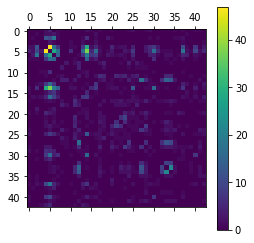

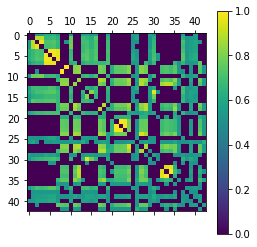

In [68]:
plt.figure(figsize=(12,6))
#plt.subplot(121)
plt.matshow(ws_obs)
plt.colorbar()
#plt.subplot(122)
plt.matshow(ws_per);
plt.colorbar()

ws_obs y ws_per son ambas matrices de adyacencia y se usa la siguiente instrucción para construir el grafo

In [5]:
G_obs = nx.from_numpy_matrix(ws_obs)# usar opción parallel_edges=False si se usa una matriz de ints

In [6]:
umbral = 0.5
ws_per[ws_per<=umbral] = 0.0

G_per = nx.from_numpy_matrix(ws_per)

La métrica para medir la cercanía se obtiene a partir de cuestionarios. Este valor varía entre 0 y 1. Un problema con esta codificación es que aun para individuos con muy poca interacción percibida esta variable va a tomar un valor cercano a cero, pero no cero. Al construir el grafo se tenderá una arista entre dos individuos, cuando en la practica esa interacción debería considerarse nula. Para solucionar esto vamos a considerar que cuando el valor de interacción percibida es menor de 0.5 lo convertimos a cero; esto es, no hay una interacción efectiva.

## Visualización

Elegimos una disposición (layout)

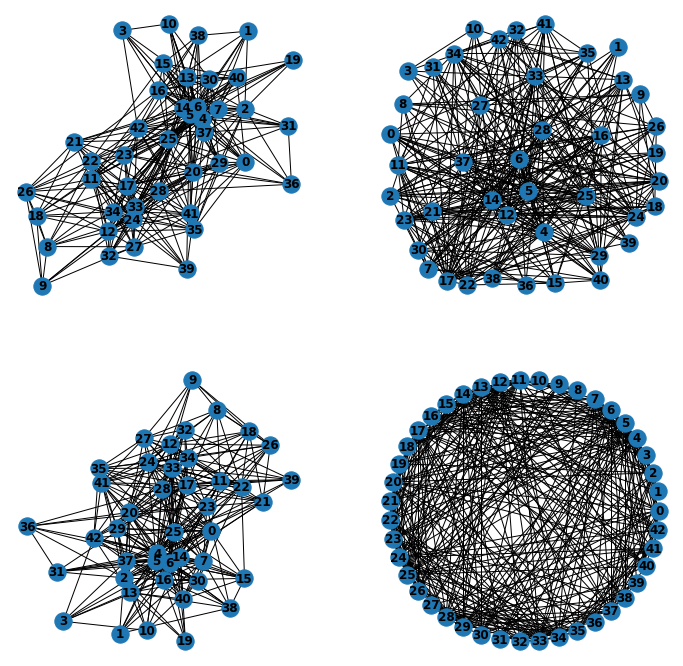

In [61]:
plt.figure(figsize=(12,12))
plt.subplot(221)
nx.draw(G_obs, with_labels=True, font_weight='bold')
plt.subplot(222)
layout=nx.spring_layout(G_obs, 4)
nx.draw(G_obs, layout, with_labels=True, font_weight='bold')
plt.subplot(223)
layout=nx.fruchterman_reingold_layout(G_obs)
nx.draw(G_obs,layout, with_labels=True, font_weight='bold')
plt.subplot(224)
layout=nx.circular_layout(G_obs)
nx.draw(G_obs,layout, with_labels=True, font_weight='bold')

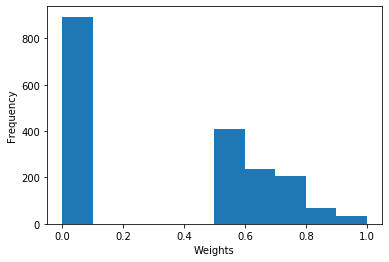

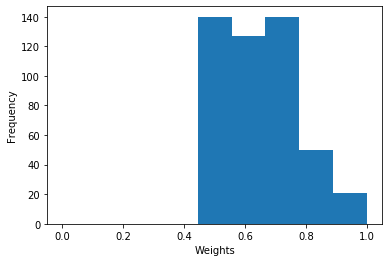

In [8]:
plt.figure()
plt.hist(ws_per.flatten())
plt.ylabel('Frequency')
plt.xlabel('Weights');

plt.figure()
nodo_salida = [n1 for n1, n2, att in G_per.edges(data=True)]
nodo_entrada = [n2 for n1, n2, att in G_per.edges(data=True)]
weights = [att['weight'] for n1, n2, att  in G_per.edges(data=True)]
plt.hist(weights,bins=np.linspace(0,1,10));
plt.ylabel('Frequency')
plt.xlabel('Weights');

## Caracterización y análisis de la red
### Características generales, número de nodos (V) y aristas (E)

In [9]:
print(nx.info(G_obs))
print('Is weigthed:',nx.is_weighted(G_obs))

G_obs.number_of_nodes(), G_obs.number_of_edges()

Name: 
Type: Graph
Number of nodes: 43
Number of edges: 336
Average degree:  15.6279
Is weigthed: True


(43, 336)

In [10]:
print(nx.info(G_per))
print('Is weigthed:',nx.is_weighted(G_per))

G_per.number_of_nodes(), G_per.number_of_edges()

Name: 
Type: Graph
Number of nodes: 43
Number of edges: 478
Average degree:  22.2326
Is weigthed: True


(43, 478)

In [62]:
# Para ver una lista de aristas o nodos
e = G_obs.edges
pd.DataFrame.from_dict(e).rename(columns={0: "Nodo de salida", 1: "Nodo de entrada"})

,Nodo de salida,Nodo de entrada
0,0,4
1,0,5
2,0,7
3,0,14
4,0,15
...,...,...
331,35,42
332,37,39
333,37,40
334,37,42


## ¿Las redes tienen loops o aristas múltiples? ¿Son redes completamente conectadas?

In [12]:
# Están conectados?
nx.is_connected(G_obs), nx.is_connected(G_per)

(True, True)

In [13]:
# Tienen multiples aristas
G_obs.is_multigraph(), G_per.is_multigraph()

(False, False)

## Otras características topológicas de la red
¿Cuál es el diámetro de la red? ¿Cuáles son los vertices que determinan ese diámetro? La función para calcular el diámetro tienen en cuenta los pesos de las aristas.

In [14]:
nx.diameter(G_obs), nx.diameter(G_per)

(3, 3)

La densidad de un grafo es el cociente entre el número de aristas de un grafo y el número de todos las posibles aristas. Como nuestras dos redes tienen el mismo número de nodos, estamos determinando algo que ya habíamos visto antes, la red de relaciones percibidas tiene más conexiones que la red de relaciones observadas.

In [15]:
nx.density(G_obs), nx.density(G_per)

(0.37209302325581395, 0.5293466223698782)

La densidad de la segunda red es alta comparada con lo común para redes sociales.

El coeficiente de clustering global que vimos en clase se calcula en average_clustering.

In [16]:
nx.average_clustering(G_obs), nx.average_clustering(G_per)

(0.6534338903754252, 0.8652893662056299)

In [17]:
nx.transitivity(G_obs), nx.transitivity(G_per)

(0.5638826959355171, 0.819492883400886)

La red de interacciones percibidas tiene un coeficiente de clustering mayor que la observada. indicando que los individuos asumen una intensidad de interacciones mayor que la registrada durante los 31 días de observaciones. En particular lo que podemos ver es que en la red de interacciones percibidas hay bastantes individuos para quienes el grupo supone que tienen contactos que a su vez están muy conectados entre sí.

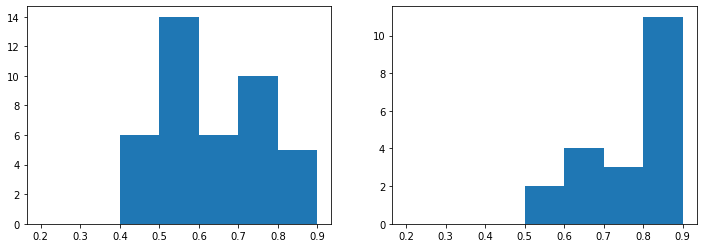

In [18]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(nx.clustering(G_obs).values(),bins=np.arange(0.2,1,0.1));
plt.subplot(122)
plt.hist(nx.clustering(G_per).values(),bins=np.arange(0.2,1,0.1));

## Grados totales, de entrada y de salida


In [19]:
G_obs.degree, G_per.degree

(DegreeView({0: 15, 1: 7, 2: 15, 3: 7, 4: 26, 5: 31, 6: 28, 7: 17, 8: 10, 9: 7, 10: 7, 11: 19, 12: 19, 13: 17, 14: 25, 15: 11, 16: 18, 17: 26, 18: 11, 19: 6, 20: 21, 21: 12, 22: 17, 23: 19, 24: 23, 25: 25, 26: 12, 27: 13, 28: 24, 29: 17, 30: 12, 31: 8, 32: 10, 33: 19, 34: 20, 35: 13, 36: 7, 37: 20, 38: 9, 39: 8, 40: 12, 41: 15, 42: 14}),
 DegreeView({0: 18, 1: 20, 2: 23, 3: 20, 4: 21, 5: 22, 6: 22, 7: 28, 8: 21, 9: 23, 10: 21, 11: 23, 12: 21, 13: 22, 14: 22, 15: 20, 16: 21, 17: 23, 18: 24, 19: 26, 20: 18, 21: 21, 22: 21, 23: 21, 24: 22, 25: 18, 26: 38, 27: 22, 28: 24, 29: 29, 30: 22, 31: 10, 32: 18, 33: 21, 34: 18, 35: 27, 36: 19, 37: 24, 38: 20, 39: 37, 40: 22, 41: 26, 42: 17}))

In [20]:
df = pd.DataFrame(G_per.degree,columns=['Node','Degree']).set_index('Node')
df

,Degree
Node,
0,18
1,20
2,23
3,20
4,21
5,22
6,22
7,28
8,21


In [21]:
df.sort_values('Degree',ascending=False)

,Degree
Node,
26,38
39,37
29,29
7,28
35,27
19,26
41,26
37,24
28,24


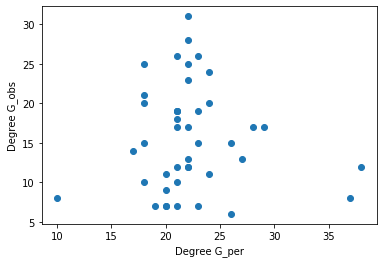

In [22]:
degree_per = [d for n, d in G_per.degree]
degree_obs = [d for n, d in G_obs.degree]

plt.scatter(degree_per,degree_obs);
plt.xlabel('Degree G_per')
plt.ylabel('Degree G_obs');

In [23]:
np.corrcoef(degree_per,degree_obs)

array([[ 1.        , -0.04875002],
       [-0.04875002,  1.        ]])

No se observa una relación entre el grado que predice el grupo para cada individuo, y el grado que se observado.

Vamos a analizar con más detalle las distribuciones de grado, calculando las distribuciones de los grados y las distribuciones acumuladas. A partir de éstas, podemos realizar los correspondientes gráficos.

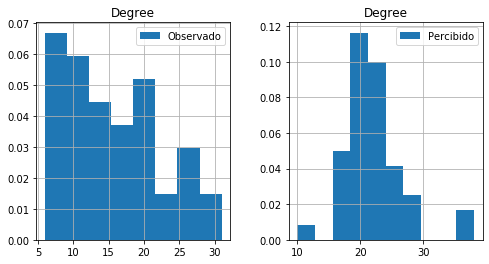

In [24]:
df_per_degree = pd.DataFrame(G_per.degree,columns=['Node','Degree']).set_index('Node')
df_obs_degree = pd.DataFrame(G_obs.degree,columns=['Node','Degree']).set_index('Node')

plt.figure(figsize=(8,4))
df_obs_degree.hist(bins=8,density=True,ax=plt.subplot(121),label='Observado');
plt.legend()
df_per_degree.hist(density=True,ax=plt.subplot(122),label='Percibido');
plt.legend();

En ambas redes vemos que hay un número bajo de nodos de alto grado y varios de grado menor. Los siguientes gráficos muestran como se observa este fenómeno en los gráficos de distribuciones acumuladas. También podemos ver que la variación en ambas curvas no es la misma.

<Figure size 576x288 with 0 Axes>

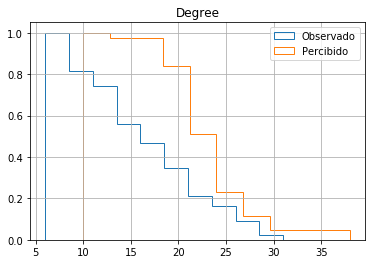

In [25]:
plt.figure(figsize=(8,4));
df_obs_degree.hist(density=True, histtype='step',label='Observado', cumulative=-1);
df_per_degree.hist(density=True,ax=plt.gca(), histtype='step',label='Percibido', cumulative=-1);
plt.legend();

## Mundos pequeños
Estas redes son relativamente chicas como para intentar probar si son de mundo pequeño, pero podemos probar.

In [26]:
degree_obs = [d for n, d in G_obs.degree]
degree_per = [d for n, d in G_per.degree]

obs_fit = powerlaw.Fit(degree_obs, fit_method='KS', discrete=True, xmin=9) 
per_fit = powerlaw.Fit(degree_per, fit_method='KS', discrete=True, xmin=17)

/home/zero/Apps/miniconda3/envs/dmcyt2019/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [27]:
per_fit.alpha, per_fit.D, per_fit.xmin

(4.377150932725694, 0.26413541728500467, 17.0)

In [28]:
obs_fit.alpha, obs_fit.D, obs_fit.xmin

(2.4830976432175484, 0.21782671181289398, 9.0)

El otro criterio para probar que una red es de mundo pequeño es demostrar que sus coeficientes de clustering son mayores que grafos al azar con características topológicas similares. Esto lo vamos a probar para la red de interacciones observadas simulando 1000 redes al azar.

con la función barabasi_albert_graph creamos grafos al azar que siguen el modelo de Barabási–Albert (un modelo de redes libres de escala). Y luego con la función gnm_random_graph generamos grafos de acuerdo al modelo de Erdos-Renyi, en este caso pasamos como argumento el número de nodos y aristas, y se van creando aristas al azar.

In [29]:
# Número de aristas promedio
G_obs.number_of_edges()/G_obs.number_of_nodes()

7.813953488372093

/home/zero/Apps/miniconda3/envs/dmcyt2019/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


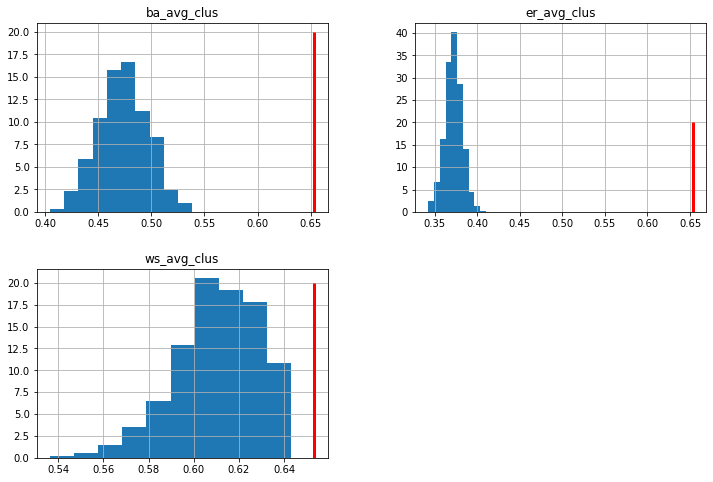

In [69]:
repetitions = 1000
data = []
for i in range(repetitions):
    d = {}
    G = nx.barabasi_albert_graph(G_obs.number_of_nodes(),10,seed=i)
    d['ba_avg_clus'] = nx.average_clustering(G)
    d['ba_avg_degree'] = G.number_of_edges()/G.number_of_nodes()
    d['ba_alpha'] = powerlaw.Fit([d for n, d in G.degree],discrete=True,xmin=8).alpha
    G = nx.gnm_random_graph(G_obs.number_of_nodes(),G_obs.number_of_edges())    
    d['er_avg_clus'] = nx.average_clustering(G)
    G = nx.watts_strogatz_graph(G_obs.number_of_nodes(),8,0.02)
    d['ws_avg_clus'] = nx.average_clustering(G)
    data.append(d)

df = pd.DataFrame(data)
axs = df.filter(regex='avg_clus').hist(figsize=(12,8),density=True)
for ax in axs.flatten():
    ax.vlines(nx.average_clustering(G_obs),0,20,lw=3,color='r')

Podemos ver los valores de alpha de la distribución powerlaw ajustada al modelo de Baravasi Albert, para ver si dieron algo razonable

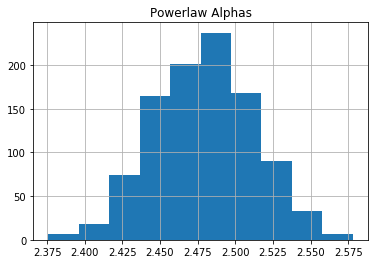

In [31]:
plt.figure()
df['ba_alpha'].hist();
plt.title('Powerlaw Alphas');

## Cálculo de la asortividad

En ambos casos los valores de asortividad sugieren que no hay asociaciones preferenciales por un lado entre nodos de alto grado, y por el otro entre los de bajo grado.

In [32]:
nx.degree_assortativity_coefficient(G_obs), nx.degree_assortativity_coefficient(G_per)

(-0.14696516028902537, -0.05034804979100025)

## Otras medias de centralidad
Es posible calcular las medias de centralidad que vimos en lcase (ademas de la centralidad de grado):

- Intermediación (betweenness)

- Cercanía (Closeness)

- Centralidad de autovectores (Eigenvector centrality)

En las salidas siguientes se muestran llamadas a las distintas funciones de centralidad, y se muestran los 10 
individuos con valores mayores para cada medida y red.


In [33]:
pos = nx.spring_layout(G_obs,k=0.2)

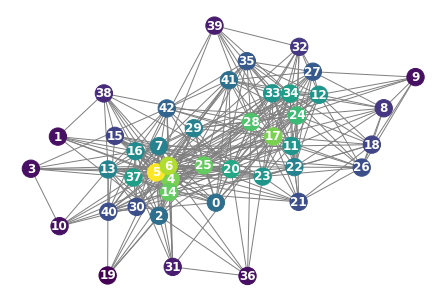

In [34]:
centrality = nx.degree_centrality(G_obs)
values = [v for n,v in centrality.items()]
nx.draw(G_obs,pos=pos, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray')

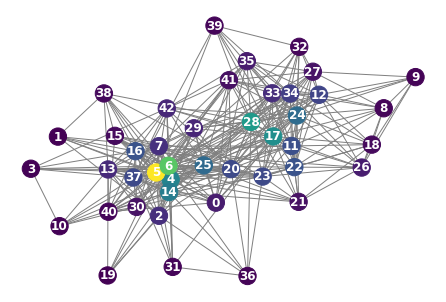

In [35]:
centrality = nx.betweenness_centrality(G_obs)
values = [v for n,v in centrality.items()]
nx.draw(G_obs,pos=pos, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray')

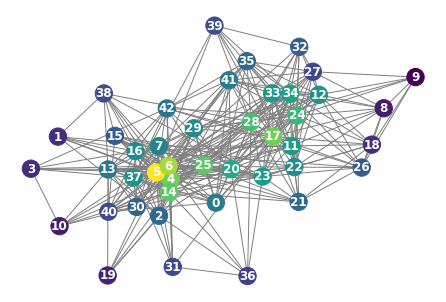

In [36]:
centrality = nx.closeness_centrality(G_obs)
values = [v for n,v in centrality.items()]
nx.draw(G_obs,pos=pos, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray')

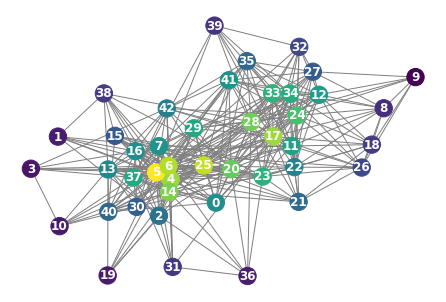

In [37]:
centrality = nx.eigenvector_centrality(G_obs)
values = [v for n,v in centrality.items()]
nx.draw(G_obs,pos=pos, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray')


## Comunidades

In [38]:
def partition_set_to_dict(m):
    d = {}
    for i,c in enumerate(m):
        for n in c:
            d[n] = i
    return d

### Girvan newman

Crea grafos desconectados removiendo aristas elegidas según su valor de centralidad de aristas por cercanía (edge betweenness centrality)

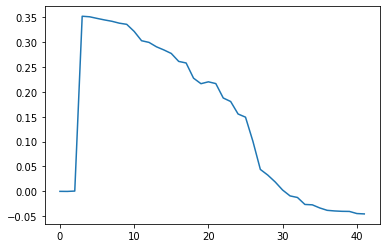

In [39]:
modulos = nx.community.girvan_newman(G_obs)
modulos = list(modulos)
modularity = []
for m in modulos:
    modularity.append(community.modularity(partition_set_to_dict(m),G_obs))
plt.plot(modularity);
idx = np.argmax(modularity)
m = modulos[idx]

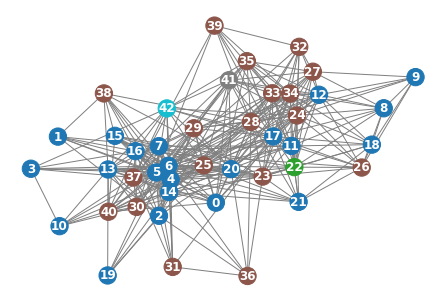

In [40]:
plt.figure()
values = [v for n,v in partition_set_to_dict(m).items()]
nx.draw(G_obs,pos=pos, with_labels=True,cmap=plt.cm.tab10,font_weight='bold',node_color = values, font_color='white', edge_color='gray')

### Louvian

El módulo community usa el método de louvian. Para la red Observada

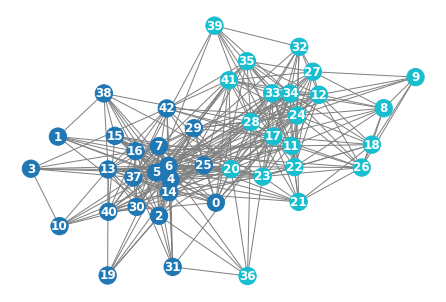

In [41]:
modulos = community.best_partition(G_obs)
values_obs = [v for n,v in modulos.items()]
nx.draw(G_obs,pos=pos, with_labels=True,cmap=plt.cm.tab10,font_weight='bold',node_color = values_obs, font_color='white', edge_color='gray')

Para la red percibida

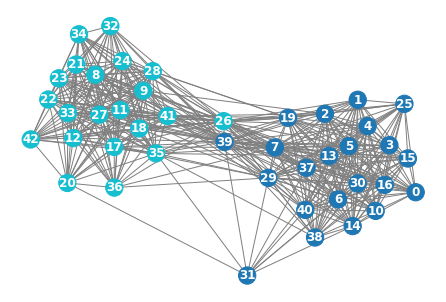

In [77]:
modulos = community.best_partition(G_per)
values_per = [v for n,v in modulos.items()]
nx.draw(G_per, with_labels=True,cmap=plt.cm.tab10,font_weight='bold',node_color = values_per, font_color='white', edge_color='gray')

Comparamos si las divisiones en comunidades para las dos redes es parecida

In [43]:
adjusted_rand_score(values_obs,values_per)

0.8182848897134611